# Prior estimation with Baseball Data
Comparison of the Empirical Reference Prior (ERP) to the James-Stein and MLE estimators
with the Efron Baseball dataset.

In [18]:
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot, likelihoodmat

using Random: seed!
using Distributions
using PyPlot
using CSV
using LinearAlgebra
linspace(x...) = LinRange(x...) |> collect
midpoints(min, max, n) = [min + (max-min) / n * (i-1/2) for i=1:n]

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);

In [19]:
table = CSV.read("baseballdata.csv")

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingHits
,String,String,Int64,Int64,Float64,Int64,Int64
1,Roberto,Clemente,45,18,0.4,367,127
2,Frank,Robinson,45,17,0.378,426,127
3,Frank,Howard,45,16,0.356,521,144
4,Jay,Johnstone,45,15,0.333,275,61
5,Ken,Berry,45,14,0.311,418,114
6,Jim,Spencer,45,14,0.311,466,126
7,Don,Kessinger,45,13,0.289,586,155
8,Luis,Alvarado,45,12,0.267,138,29
9,Ron,Santo,45,11,0.244,510,137


In [20]:
xs = midpoints(0.1, 0.5, 300)

data = table[:,:BattingAverage]
M = length(data)
N = 45
σ = sqrt(mean(data) * (1 - mean(data)) / N)

0.06582090626055082

In [21]:
# cross validation routine
function cverp(m, data; ncv=10, rs = linspace(0.01,0.1,ncv))
    regs = [ReferenceRegularizer(m, r) for r in rs]
    @time ss = [cvscore(m, data, dd->ebprior(m, dd, r, OPTCONFIG)) for r in regs]
    @show reg = rs[argmax(ss)]
    plot(rs, ss)
    ebprior(m,  data, ReferenceRegularizer(m,  reg), OPTCONFIG), reg
end

cverp (generic function with 1 method)

In [22]:
B = 1 - (M - 3) * σ^2 / sum((data .- mean(data)).^2)
μ_js = mean(data)
σ_js = sqrt(B * σ^2 / (1 - B))

w_js = normalize(pdf.(Normal(μ_js, σ_js), xs), 1);

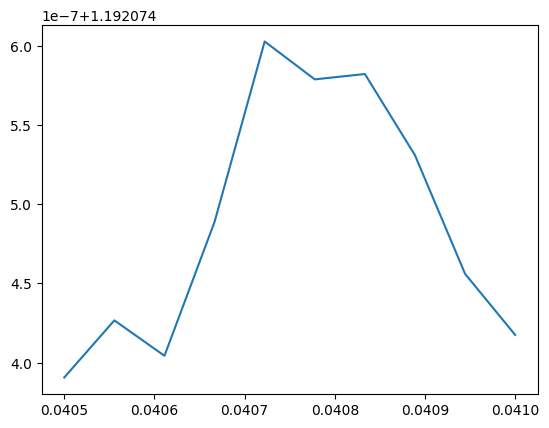

  7.127250 seconds (4.38 M allocations: 48.659 GiB, 19.73% gc time)
reg = rs[argmax(ss)] = 0.04072222222222223


([3.2573534108462623e-10, 3.956441340635696e-10, 4.818272015384601e-10, 5.883052974804293e-10, 7.201380140673554e-10, 8.837017278978903e-10, 1.0870427100794847e-9, 1.340327723471331e-9, 1.6564183167364039e-9, 2.0516041217214753e-9  …  2.9620359084300694e-11, 2.5372121003846573e-11, 2.1799720662031943e-11, 1.8787817623695064e-11, 1.624186963353596e-11, 1.4084214567259199e-11, 1.2250807718179943e-11, 1.0688905690906795e-11, 9.354811662018263e-12, 8.21230450985971e-12], 0.04072222222222223)

In [23]:
m = FEModel(f=x->x, xs=xs, σ=σ)

w_er, reg = cverp(m, data, rs = linspace(0.0405,0.041,10))

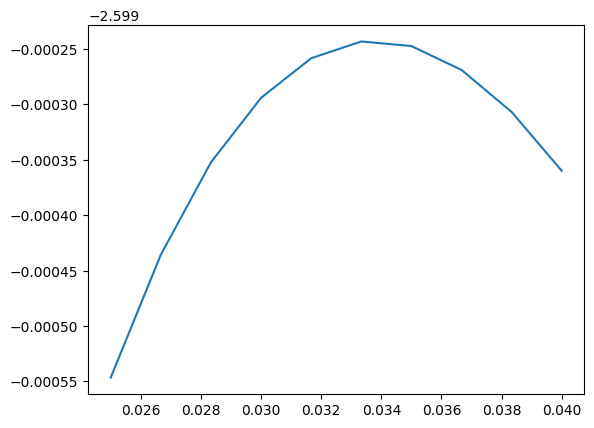

  7.985140 seconds (3.24 M allocations: 53.364 GiB, 20.44% gc time)
reg = rs[argmax(ss)] = 0.03333333333333333


([3.641203019716438e-13, 4.746004485393323e-13, 6.29831541672653e-13, 8.397010547632905e-13, 1.1060077968249284e-12, 1.4564420659338131e-12, 1.957529091080717e-12, 2.641003951910239e-12, 3.5836950603491512e-12, 4.88521947501143e-12  …  1.4100074635554567e-12, 1.1785714271094462e-12, 9.90820503107911e-13, 8.272474321451394e-13, 6.874525337536933e-13, 5.713495769312758e-13, 4.770523038652454e-13, 4.0143634486487525e-13, 3.41075042141489e-13, 2.9282524096271865e-13], 0.03333333333333333)

In [24]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

data_bin = round.(Int, data * N)
w_bin, reg = cverp(m_bin, data_bin, rs = linspace(0.025,0.04,10))

#figure()
#plot(xs, w_bin)

In [42]:
L=likelihoodmat(m, data)
function posteriors(w)
    post = w .* L'
    post = post ./ sum(post, dims=1)
end

posteriormeans(w) = posteriors(w)' * xs

truth = table[:, :RemainingHits] ./ table[:, Symbol("RemainingAt-Bats")]

function errors(w)
    posteriormeans(w) - truth
end

mse(w) = mean(x->x^2, errors(w))

mse (generic function with 1 method)

In [26]:
# compute the individual posteriors
posts = hcat((posteriormeans(w) for w in [w_js, w_er, w_bin])...)

18×3 Array{Float64,2}:
 0.293979  0.303475  0.298279
 0.289306  0.296413  0.292434
 0.284634  0.28936   0.286573
 0.279749  0.28217   0.280531
 0.275076  0.275612  0.274927
 0.275076  0.275612  0.274927
 0.270404  0.269464  0.269568
 0.265731  0.263779  0.264508
 0.260846  0.258345  0.259569
 0.260846  0.258345  0.259569
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.251501  0.249297  0.25114 
 0.246828  0.245349  0.247401
 0.242156  0.241719  0.243946

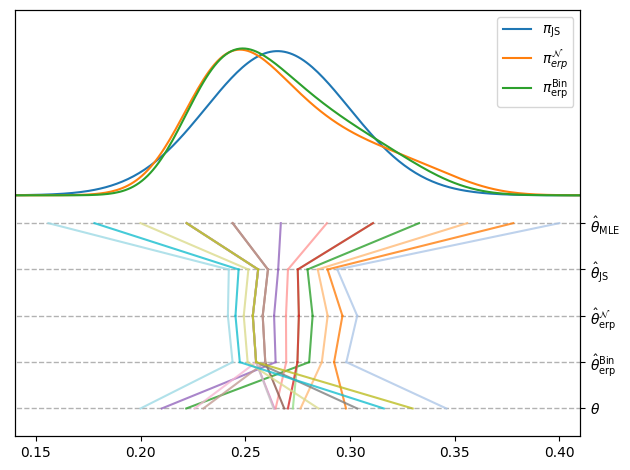

In [27]:
fig, ax1 = subplots()

xmin, xmax = .14, .41
ymin, ymax = -0.026, 0.02

plot(xs, w_js, label="\$\\pi_{\\rm JS}\$")
plot(xs, w_er, label="\$\\pi^{\\mathcal{N}}_{erp}\$")
plot(xs, w_bin, label="\$\\pi^{\\rmBin}_{\\rmerp}\$")
legend()

#grid(which="major",axis="both", alpha=0.2)

xlim(xmin, xmax)
ylim(ymin, ymax)
ax1.set_yticks([])

#subplot(212, sharex=ax1)
offset = -0.003
scale=-5e-3

dots = hcat(data, posts, truth)
scale = scale=-5e-3

yt = vcat([0,1,2,3,4] .* scale.+offset)
ytl = vcat(["\$\\hat\\theta_{\\rmMLE}\$",
        "\$\\hat\\theta_{\\rmJS}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\mathcal{N}}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\rmBin}\$", 
        "\$\\theta\$"])

ax2 = ax1.twinx()
#ax2.yaxis.set_label_position("right")


ax2.set_ylim(ymin , ymax)
ax2.set_yticks(yt)
ax2.set_yticklabels(ytl)

ax2.hlines([0,1,2,3,4] .* scale.+offset, 0, 1, linewidth=1, alpha=0.3, linestyle="dashed")

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        ax2.plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale.+offset, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end
fig.tight_layout()
savefig("baseball.pdf", bbox_inches="tight")

In [28]:
# compute mean squared errors
mse_ml = mean(x->x^2, data - truth)
@show mse_ml
@show mse(w_js) / mse_ml
@show mse(w_er) / mse_ml
@show mse(w_bin) / mse_ml

mse_ml = 0.004764985095190408
mse(w_js) / mse_ml = 0.31242256652523565
mse(w_er) / mse_ml = 0.3123379695680969
mse(w_bin) / mse_ml = 0.30966519093466754


0.30966519093466754

In [29]:
# print results in latex table
using Printf
spf(x) = Printf.@sprintf("%.3f", x)

function latex_table()
    digits = 3
    let posts = round.(posts, digits=digits), 
        data = round.(data, digits=digits),
        truth = round.(truth, digits=digits)
    for i=1:18
        if i%2 == 1
            println("\\rowcolor{black!20}")
            end
        println("$(table[i,2]) & " *
            "\$$(spf(data[i])) = \\nicefrac{$(table[i,4])}{45}\$ & " *
            "\$$(spf(posts[i,1])) \$& \$$(spf(posts[i,2]))\$ & \$$(spf(posts[i,3]))\$ & " *
            "\$$(truth[i]) = \\nicefrac{$(table[i,7])}{$(table[i,6])} &" *
            "\\\\"
            )
    end
    end
end
latex_table()

\rowcolor{black!20}
Clemente & $0.400 = \nicefrac{18}{45}$ & $0.294 $& $0.303$ & $0.298$ & $0.346 = \nicefrac{127}{367} &\\
Robinson & $0.378 = \nicefrac{17}{45}$ & $0.289 $& $0.296$ & $0.292$ & $0.298 = \nicefrac{127}{426} &\\
\rowcolor{black!20}
Howard & $0.356 = \nicefrac{16}{45}$ & $0.285 $& $0.289$ & $0.287$ & $0.276 = \nicefrac{144}{521} &\\
Johnstone & $0.333 = \nicefrac{15}{45}$ & $0.280 $& $0.282$ & $0.281$ & $0.222 = \nicefrac{61}{275} &\\
\rowcolor{black!20}
Berry & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.273 = \nicefrac{114}{418} &\\
Spencer & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.27 = \nicefrac{126}{466} &\\
\rowcolor{black!20}
Kessinger & $0.289 = \nicefrac{13}{45}$ & $0.270 $& $0.269$ & $0.270$ & $0.265 = \nicefrac{155}{586} &\\
Alvarado & $0.267 = \nicefrac{12}{45}$ & $0.266 $& $0.264$ & $0.265$ & $0.21 = \nicefrac{29}{138} &\\
\rowcolor{black!20}
Santo & $0.244 = \nicefrac{11}{45}$ & $0.261 $& $0.258$ & $0.260$ & $0.269 =

## Comparison of true leave-1-out estimation vs whole data

In [92]:
gmin = 0
gmax = 1
trace = false
maxiters = 1000
rel_tol = 1e-3
#@time cvreg, opt = ObjectiveEmpiricalBayes.cvreference(m, data, gmin, gmax; c=OPTCONFIG, show_trace=trace, iterations=maxiters, rel_tol=rel_tol)
#opt

0.001

Computing CV  1


┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50


opt = Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 6.625236e-06
 * Minimum: -2.716765e+00
 * Iterations: 37
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 38
Computing ERP 1
Computing CV  2


┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50


opt = Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 8.064512e-03
 * Minimum: -2.653450e+00
 * Iterations: 22
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 23
Computing ERP 2
Computing CV  3
opt = Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 3.698741e-02
 * Minimum: -2.611492e+00
 * Iterations: 19
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 20
Computing ERP 3
Computing CV  4
opt = Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 4.962381e-02
 * Minimum: -2.586771e+00
 * Iterations: 19
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 20
Computing ERP 4
Computing C

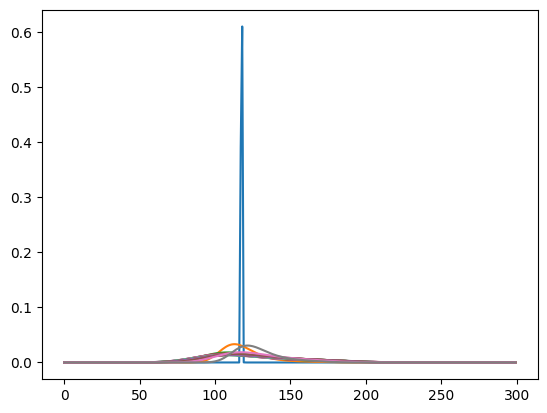

opt = Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 8.675080e-03
 * Minimum: -2.651330e+00
 * Iterations: 22
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 23
Computing ERP 18
217.510489 seconds (30.44 M allocations: 1.199 TiB, 15.33% gc time)


0-element Array{Any,1}

In [94]:
loo = [] # leave one out point estimates
wis = []
cvregs = []
@time for i = 1:18
    println("Computing CV  $i")
    data_loo = deleteat!(copy(data), i)
    cvreg, opt = ObjectiveEmpiricalBayes.cvreference(m, data_loo, gmin, gmax; c=OptConfig(XTOLABS=1e-6), show_trace=trace, iterations=maxiters, rel_tol=rel_tol)
    @show opt
    println("Computing ERP $i")
    wi = ebprior(m, data_loo, ReferenceRegularizer(m, cvreg), OptConfig(XTOLABS=1e-6));
    push!(cvregs, cvreg)
    push!(wis, wi)
    plot(wi)
end
plot()

In [98]:
maximum(hcat(wis ...), dims=1) |> vec

18-element Array{Float64,1}:
 0.6104172785643331  
 0.033245498090977044
 0.018349749267300583
 0.015934750703530214
 0.014869517064512857
 0.014869517064512857
 0.01398790503027703 
 0.013451918688995347
 0.01336255775876015 
 0.01336255775876015 
 0.013795389291365033
 0.013795389291365033
 0.013795389291365033
 0.013795389291365033
 0.013795389291365033
 0.015227266499324443
 0.018616669355283947
 0.030720653651033377

In [75]:
loo = [posteriormeans(wi)[i] for i=1:18]
mse_loo = mean(x->x^2, loo - truth)
@show mse_loo / mse_ml;

mse_loo / mse_ml = 0.39372415929991794


In [84]:
dots2 = hcat(dots, loo)

18×6 Array{Any,2}:
 0.4    0.293979  0.303475  0.298279  0.346049  0.257496
 0.378  0.289306  0.296413  0.292434  0.298122  0.270874
 0.356  0.284634  0.28936   0.286573  0.276392  0.28326 
 0.333  0.279749  0.28217   0.280531  0.221818  0.281113
 0.311  0.275076  0.275612  0.274927  0.272727  0.275531
 0.311  0.275076  0.275612  0.274927  0.270386  0.275531
 0.289  0.270404  0.269464  0.269568  0.264505  0.269204
 0.267  0.265731  0.263779  0.264508  0.210145  0.263197
 0.244  0.260846  0.258345  0.259569  0.268627  0.257859
 0.244  0.260846  0.258345  0.259569  0.23      0.257859
 0.222  0.256174  0.253613  0.255189  0.263941  0.254215
 0.222  0.256174  0.253613  0.255189  0.225806  0.254215
 0.222  0.256174  0.253613  0.255189  0.303448  0.254215
 0.222  0.256174  0.253613  0.255189  0.263538  0.254215
 0.222  0.256174  0.253613  0.255189  0.329949  0.254215
 0.2    0.251501  0.249297  0.25114   0.284946  0.2528  
 0.178  0.246828  0.245349  0.247401  0.316176  0.255001
 0.156  0.24

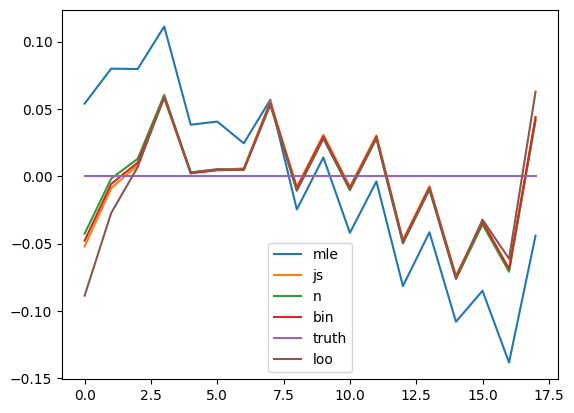

PyObject <matplotlib.legend.Legend object at 0x7f1e57c09690>

In [88]:
plot(dots2.-truth)
legend(["mle","js", "n", "bin", "truth", "loo"])